# Test VOLVuLuS
Use a trained 3D U-Net model created by `VOLVuLuS_train.ipynb` to predict segmentation maps for MRI images.

## Import packages

In [1]:
import VOLVuLuS_settings as settings
from thesis_common import read_images, read_groundtruths, convert_pred_to_img_3d, group_images,\
    show_image, create_hdf5_db_3d

from dltoolkit.utils.generic import list_images
from dltoolkit.nn.segment import UNet_3D_NN
from dltoolkit.utils.visual import plot_roc_curve, plot_precision_recall_curve,\
    print_confusion_matrix, print_classification_report

import os, cv2, shutil, time
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

/Users/geoff/anaconda3/envs/ML3-DL-OPENCV/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Determine test/inference settings
Set `IS_INFERENCE` to `False` to create segmentation maps for test MRI images for which ground truths **are** available. This is typically used to obtain a final test error estimate at the very end of the training process. Set it to `False` to use a trained model for MRI images for which ground truths are not available, i.e. simulating a production scenario.

During development set `IS_DEVELOPMENT` to `True` to always use the training data set. 

In [2]:
IS_INFERENCE = False
IS_DEVELOPMENT = True

# Path to the trained model to load
Enter the full path to the saved trained model here.

In [3]:
# TRAINED_MODEL_NAME = "../savedmodels/VOLVuLuS_UNet3D_brain_2layer_ep200.model"
TRAINED_MODEL_NAME = "../savedmodels/VOLVuLuS_UNet3D_brain_3layer_ep200.model"

# Convert test data to HDF5
The first function `perform_hdf5_conversion_test()` converts data in the `test3d` folder to HDF5. Data comprises MRI images as well as their ground truths. This function is used to apply a trained model to MRI images for which ground truths are available so that various performance metrics can be calculated.

The second function `perform_hdf5_conversion_inference()` does the same but does not include ground truths. It is used to apply a trained model to MRI images for which ground truths are not available, e.g. in a production environment.

**Note**: during development and pipeline testing neither function is used. Instead, the training/validation set is used, the same sets used to train the model.

In [4]:
def perform_hdf5_conversion_test(settings):
    # Prepare the path to the TEST images AND ground truths. Note that the data is NOT shuffled.
    img_path = os.path.join(settings.TEST_PATH, settings.FLDR_IMAGES)
    msk_path = os.path.join(settings.TEST_PATH, settings.FLDR_GROUND_TRUTH)

    # Create a list of paths to the individual patient folders
    patient_fld_imgs = sorted([os.path.join(img_path, e.name) for e in os.scandir(img_path) if e.is_dir()])
    patient_fld_masks = sorted([os.path.join(msk_path, e.name) for e in os.scandir(msk_path) if e.is_dir()])

    # Create the HDF5 data sets
    output_paths = []

    # Test images
    output_paths.append(create_hdf5_db_3d(patient_fld_imgs, "test3d", img_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       img_exts=settings.IMG_EXTENSION,
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings))

    # Test ground truths
    output_paths.append(create_hdf5_db_3d(patient_fld_masks, "test3d", msk_path,
                                       (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                       img_exts=settings.IMG_EXTENSION,
                                       key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings,
                                       is_mask=True))
    
    return output_paths

def perform_hdf5_conversion_inference(settings):
    # Prepare the path to the TEST images (NO ground truths because they are not available)
    test_path = os.path.join(settings.TEST_PATH, settings.FLDR_IMAGES)

    # Create a list of paths to the individual patient folders
    test_imgs = sorted([os.path.join(test_path, e.name) for e in os.scandir(test_path) if e.is_dir()])

    print(test_imgs)
    
    # Create the HDF5 data sets
    output_paths = []

    # Test images (no ground truths available, no need to split). The assumption is only
    # relevant images are placed in the test folder, i.e. the pipeline will not exclude
    # any slices
    output_paths.append(create_hdf5_db_3d(test_imgs, "test3d", test_path,
                                        (settings.IMG_HEIGHT, settings.IMG_WIDTH, settings.IMG_CHANNELS),
                                        img_exts=settings.IMG_EXTENSION,
                                        key=settings.HDF5_KEY, ext=settings.HDF5_EXT, settings=settings))

    return output_paths

In [5]:
if IS_DEVELOPMENT:
    print("Development mode, no test set created. Using the training/validation set.")
else:
    if IS_INFERENCE:
        output_paths = perform_hdf5_conversion_inference(settings)
        print("Converted test images WITHOUT ground truths for inference: {}".format(output_paths))
    else:
        output_paths = perform_hdf5_conversion_test(settings)
        print("Converted test images WITH ground truths for model estimate: {}".format(output_paths))

Development mode, no test set created. Using the training/validation set.


# Load data
The cell below performs the actual loading of data. The assumption is that all test data fits into memory, generators are NOT used.

In [6]:
# Load the images and ground truths
if IS_DEVELOPMENT:
    # Use training images for pipeline validation and training
    print("WARNING: using TRAINING images, NOT TEST images for PIPELINE DEVELOPMENT")
    test_imgs = read_images("../data/MSC8002/training3d/train3d_images.h5", settings.HDF5_KEY, is_3D=True)
    test_ground_truths = read_groundtruths("../data/MSC8002/training3d/train3d_groundtruths.h5", settings.HDF5_KEY, is_3D=True)
else:
    if IS_INFERENCE:
        print("--- Pre-processing test images without ground truths for INFERENCE")
        # Use for inference on test images without ground truths
        test_imgs = read_images(output_paths[0], settings.HDF5_KEY, is_3D=True)
    else:
        # Use test images WITH ground truths for final model evaluation
        print("WARNING: using TEST images, NOT TRAINING images for MODEL EVALUATION")
        test_imgs = read_images(output_paths[0], settings.HDF5_KEY, is_3D=True)
        test_ground_truths = read_groundtruths(output_paths[1], settings.HDF5_KEY, is_3D=True)

Loading image HDF5: ../data/MSC8002/training3d/train3d_images.h5 with dtype = float16
Loading ground truth HDF5: ../data/MSC8002/training3d/train3d_groundtruths.h5 with dtype = uint8


# Show one image to check
Show a single image and, if available, its ground truth just as a check.

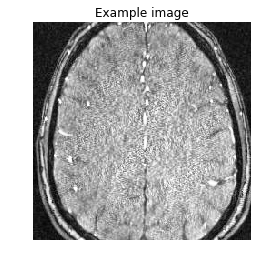

       Max image intensity: 1.0 - float16 - (3, 240, 240, 32, 1)


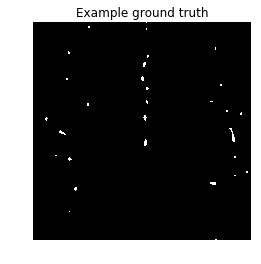

Max ground truth intensity: 255 - uint8 - (3, 240, 240, 32, 1)


In [7]:
PATIENT_ID = 0
IX = 0

show_image(np.squeeze(test_imgs[PATIENT_ID, :, :, IX, :]), 'Example image')
print("       Max image intensity: {} - {} - {}".format(np.max(test_imgs[IX]), test_imgs.dtype, test_imgs.shape))

if not IS_INFERENCE or IS_DEVELOPMENT:
    show_image(np.squeeze(test_ground_truths[PATIENT_ID, :, :, IX, :]), 'Example ground truth')
    print("Max ground truth intensity: {} - {} - {}".format(np.max(test_ground_truths[PATIENT_ID, :, :, IX, :]),
                                                            test_ground_truths.dtype,
                                                            test_ground_truths.shape))

# Load the trained model
Load the saved model located in the location specified by `TRAINED_MODEL_NAME`. Use the same `build_model_XXX()` method that was used by `VOLVuLuS_training.ipynb` to train the model. Keras is unable to load a model when a different architecture has been loaded.

In [8]:
unet = UNet_3D_NN(img_height=settings.IMG_HEIGHT,
                  img_width=settings.IMG_WIDTH,
                  num_slices=settings.SLICE_END - settings.SLICE_START,
                  img_channels=settings.IMG_CHANNELS,
                  num_classes=settings.NUM_CLASSES)
model = unet.build_model_3lyr()
# model = unet.build_model_2lyr()
model.load_weights(TRAINED_MODEL_NAME)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 240, 32, 0                                            
__________________________________________________________________________________________________
contr1_1 (Conv3D)               (None, 240, 240, 32, 896         input_1[0][0]                    
__________________________________________________________________________________________________
contr1_2 (Conv3D)               (None, 240, 240, 32, 55360       contr1_1[0][0]                   
__________________________________________________________________________________________________
contr1_mp (MaxPooling3D)        (None, 120, 120, 16, 0           contr1_2[0][0]                   
__________________________________________________________________________________________________
contr2_1 (

# Predict segmentation maps
Predict segmentation maps for all MRI images in the `test_imgs` array.

In [9]:
start_time = time.time()
print("Number of samples: {}".format(test_imgs.shape))
predictions = model.predict(test_imgs, batch_size=settings.TRN_BATCH_SIZE, verbose=2)
print("Elapsed time: {:.2f}s".format(time.time() - start_time))

Number of samples: (3, 240, 240, 32, 1)
Elapsed time: 131.37s


# Convert predictions to segmentation map images
Apply to conversion to the predictons:

- `predictions_imgs`: Convert the predictions (i.e. scores for both classes for each pixel) to a shape that can be displayed later. A threshold `TRN_PRED_THRESHOLD` is used to determine whether a pixel should be assigned the background or blood vessel class.
- `prediction_scores`: change the order of the dimensions to match (-1, slices, height, widht, score)

In [10]:
predictions_imgs = convert_pred_to_img_3d(predictions,
                                       threshold=settings.TRN_PRED_THRESHOLD,
                                       verbose=settings.VERBOSE)
prediction_scores = np.transpose(predictions, axes=(0, 3, 1, 2, 4))

Elapsed time: 0.66s


# Show/save segmentation maps
Display a single MRI image, its ground truth (if available) and the predicted segmentation map. In addition, save a number of images, ground truths and segmentation maps into a single image (one for each type) for visualization and save them to disk.

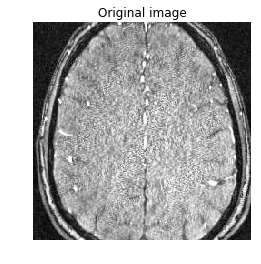

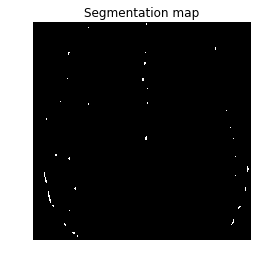

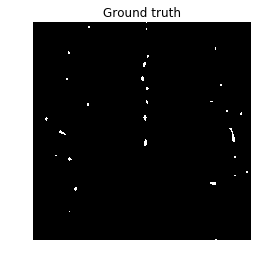

  gr truth 255 dtype uint8
  original 1.0 dtype float16
prediction 255 dtype uint8


In [11]:
# Show a single image, ground truth and segmentation map
MAX_IMAGES = len(predictions_imgs[PATIENT_ID])

test_imgs_conv = np.transpose(test_imgs, axes=(0, 3, 1, 2, 4)) 
test_ground_truths_conv = np.transpose(test_ground_truths, axes=(0, 3, 1, 2, 4)) 

show_image(np.squeeze(test_imgs_conv[PATIENT_ID, IX]), 'Original image')
show_image(np.squeeze(predictions_imgs[PATIENT_ID, IX]), 'Segmentation map')

# Plot images and segmentation maps in a single image each
group_images(test_imgs_conv[PATIENT_ID, 0:min(16, MAX_IMAGES)],
             4, 1.0, False, "../output/VOLVuLuS_" + unet.title+"_grp_images")
group_images(predictions_imgs[PATIENT_ID, 0:min(16, MAX_IMAGES), :],
             4, 1.0, False, "../output/VOLVuLuS_" + unet.title+"_grp_predictions")

if not IS_INFERENCE or IS_DEVELOPMENT:
    show_image(np.squeeze(test_ground_truths_conv[PATIENT_ID, IX]), 'Ground truth')

    # Plot a number of ground truths in a single image 
    group_images(test_ground_truths_conv[PATIENT_ID, 0:min(16, MAX_IMAGES)],
                 4, 1.0, False, "../output/VOLVuLuS_"+unet.title+"_grp_groundtruths")
    
    print("  gr truth {} dtype {}".format(np.max(test_ground_truths_conv[PATIENT_ID, IX]), test_ground_truths_conv[0].dtype))

print("  original {} dtype {}".format(np.max(test_imgs_conv[0]), test_imgs_conv[0].dtype))
print("prediction {} dtype {}".format(np.max(predictions_imgs[0]), predictions_imgs[0].dtype))

# Show metrics
The cells below produxe a number of metrics for the current model and the segmentation maps it produced. This is not possible when ground truths are not available.

## ROC curve
Plot the Receiver Operator Curve.


Area under ROC curve: 0.9862


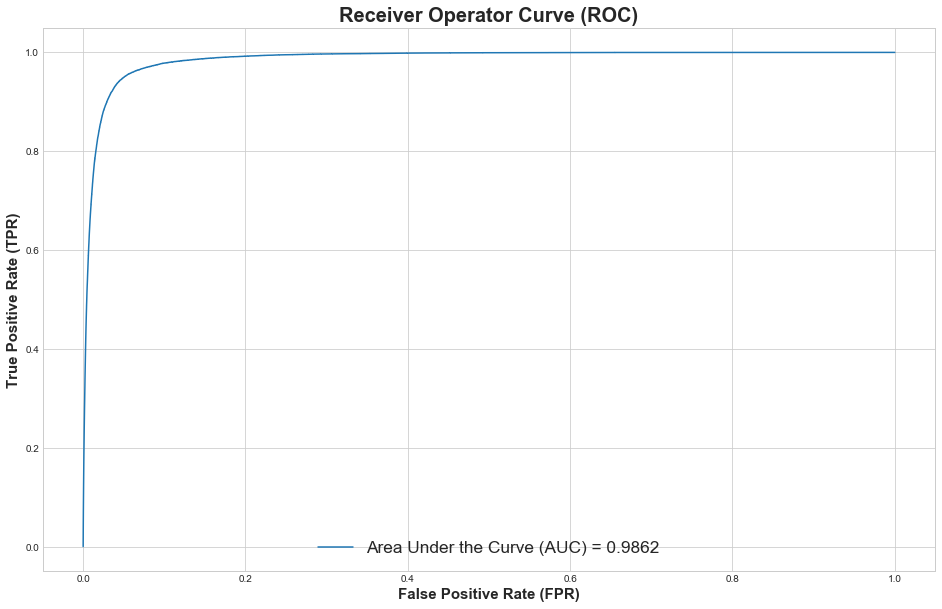

In [12]:
if not IS_INFERENCE or IS_DEVELOPMENT:
    roc_path = os.path.join(settings.OUTPUT_PATH, "VOLVuLuS_" + unet.title)
    plot_roc_curve(test_ground_truths_conv, prediction_scores[:,:,:,:,1], show=True, save_path=roc_path)

## Precision/Recall curve
Plot the Precision/Recall curve.


Area under Precision-Recall curve: 0.3483


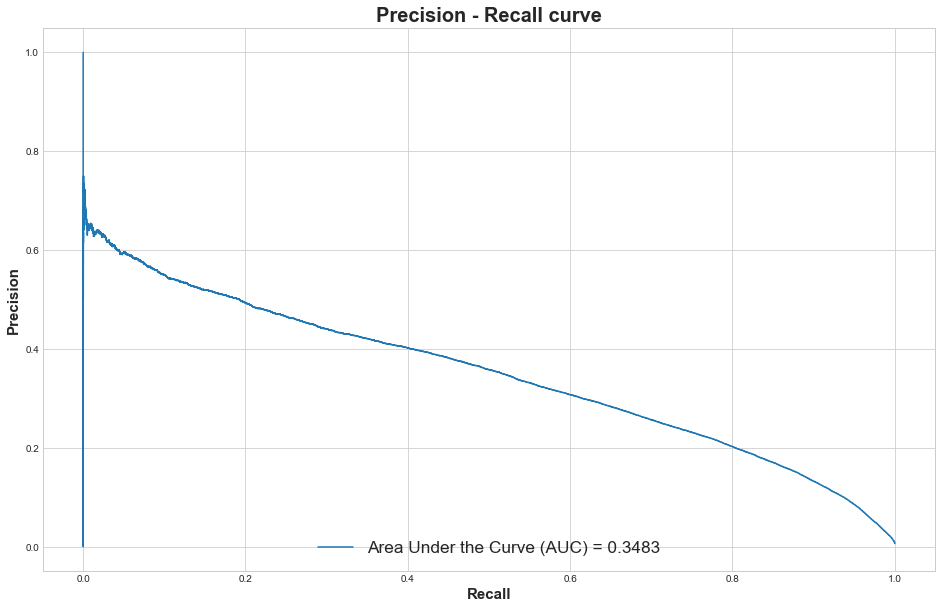

In [13]:
if not IS_INFERENCE or IS_DEVELOPMENT:
    prec_path = os.path.join(settings.OUTPUT_PATH, "VOLVuLuS_" + unet.title)
    plot_precision_recall_curve(test_ground_truths_conv, prediction_scores, settings.NUM_CLASSES, show=True, save_path=prec_path)

## Confusion matrix
Plot the pixel wise confusion matrix.

In [ ]:
if not IS_INFERENCE or IS_DEVELOPMENT:
    (conf_ind, conf_mat) = print_confusion_matrix(test_ground_truths_conv, predictions_imgs)

## Classification report
Plot the pixel wise classification report.

In [ ]:
if not IS_INFERENCE or IS_DEVELOPMENT:
    print_classification_report(test_ground_truths_conv, predictions_imgs)

# Write segmentation maps, ground truths and MRI images to disk
Save the predicted segmentation maps, ground truths (after applying the binary mask) and original MRI images to disk.

In [ ]:
# Remove existing files
SEGMAP_PATH = "../output/segmentation_maps3d/"
if os.path.exists(SEGMAP_PATH):
    shutil.rmtree(SEGMAP_PATH)
os.makedirs(SEGMAP_PATH)

In [ ]:
for patient_id in range(test_imgs_conv.shape[0]):
    for i in range(len(predictions_imgs[patient_id])):
        cv2.imwrite(SEGMAP_PATH + "segmap3d_p{}_s{}.jpg".format(patient_id, i), predictions_imgs[patient_id, i], (cv2.IMWRITE_JPEG_QUALITY, 100))

    if not IS_INFERENCE or IS_DEVELOPMENT:
        for i in range(len(test_ground_truths_conv[patient_id])):
            cv2.imwrite(SEGMAP_PATH + "groundtruth3d_p{}_s{}.jpg".format(patient_id, i), test_ground_truths_conv[patient_id, i], (cv2.IMWRITE_JPEG_QUALITY, 100))

    for i in range(len(test_imgs_conv[patient_id])):
        cv2.imwrite(SEGMAP_PATH + "image3d_p{}_s{}.jpg".format(patient_id, i), test_imgs_conv[patient_id, i].astype(np.float32)*255, (cv2.IMWRITE_JPEG_QUALITY, 100))

# Testing/inference complete